In [5]:
# ========== basics ==========
import re
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from typing import List, Union

warnings.filterwarnings("ignore")

# ==========  text  ==========
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# ==========   saving ==========
import joblib
import pickle as pkl
import ast

# ========== Scikit-learn:   ==========
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    mean_squared_error, r2_score, roc_curve, auc, ConfusionMatrixDisplay
)

# ========== Scikit-learn:   ==========
from sklearn.preprocessing import (
    LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# ========== Scikit-learn:   ==========
from sklearn.linear_model import (
    LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, HuberRegressor, LogisticRegression
)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
)
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, NearestNeighbors

# ========== Scikit-learn: ==========
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [6]:
from datasets import load_dataset

ds = load_dataset("mohammad2928git/complete_medical_symptom_dataset")

README.md:   0%|          | 0.00/776 [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/81.3M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/82.7M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/83.1M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/76.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1300022 [00:00<?, ? examples/s]

In [7]:
df = ds["train"].to_pandas()
df.head()

,text,label,symptoms,lebel_text,Code,Name,Symptoms,Treatments,AGE,DIFFERENTIAL_DIAGNOSIS,SEX,PATHOLOGY,EVIDENCES,INITIAL_EVIDENCE
0,I have been having migraines and headaches. I ...,308.0,"[migraines headaches, can't sleep, whole bod...",[drug reaction],NaN,None,None,None,NaN,None,None,None,None,None
1,I have asthma and I get wheezing and breathing...,35.0,"[asthma wheezing breathing problems, fevers, ...",[allergy],NaN,None,None,None,NaN,None,None,None,None,None
2,Signs and symptoms of primary ovarian insuffic...,798.0,[signs symptoms primary ovarian insufficiency ...,[premature ovarian failure],NaN,None,None,None,NaN,None,None,None,None,None
3,"cough,high_fever,breathlessness,family_history...",149.0,"[cough, high fever, breathlessness, family his...",[bronchial asthma],NaN,None,None,None,NaN,None,None,None,None,None
4,"chills,vomiting,high_fever,sweating,headache,n...",596.0,"[chills, vomiting, high fever, sweating, heada...",[malaria],NaN,None,None,None,NaN,None,None,None,None,None


In [8]:
# Convert unhashable columns (like lists/arrays) to strings for duplication check
df_str = df.applymap(lambda x: str(x) if isinstance(x, (list, np.ndarray)) else x)
df_str.duplicated().sum()

np.int64(18534)

In [9]:
df_str.drop_duplicates(inplace=True)
df_str.duplicated().sum()

np.int64(0)

In [10]:
df_str.isna().sum()

,0
text,1279066
label,1279066
symptoms,0
lebel_text,0
Code,1281088
Name,1281088
Symptoms,1281088
Treatments,1281089
AGE,2822
DIFFERENTIAL_DIAGNOSIS,2822


In [11]:
df_str = df_str.drop(['text', 'label', 'Code', 'Name', 'Symptoms', 'DIFFERENTIAL_DIAGNOSIS', 'PATHOLOGY', 'EVIDENCES', 'INITIAL_EVIDENCE', 'Treatments'], axis=1)
df_str.head()

,symptoms,lebel_text,AGE,SEX
0,"['migraines headaches' "" can't sleep"" ' whole ...",['drug reaction'],NaN,None
1,['asthma wheezing breathing problems' ' fevers...,['allergy'],NaN,None
2,['signs symptoms primary ovarian insufficiency...,['premature ovarian failure'],NaN,None
3,['cough' 'high fever' 'breathlessness' 'family...,['bronchial asthma'],NaN,None
4,['chills' 'vomiting' 'high fever' 'sweating' '...,['malaria'],NaN,None


In [12]:
df_str.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1281488 entries, 0 to 1300021
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   symptoms    1281488 non-null  object 
 1   lebel_text  1281488 non-null  object 
 2   AGE         1278666 non-null  float64
 3   SEX         1278666 non-null  object 
dtypes: float64(1), object(3)
memory usage: 48.9+ MB


In [13]:
df_str.isna().sum()

,0
symptoms,0
lebel_text,0
AGE,2822
SEX,2822


In [14]:
df_str['AGE'] = df_str['AGE'].fillna(df_str['AGE'].mean())
df_str['SEX'] = df_str['SEX'].fillna(df_str['SEX'].mode()[0])
df_str.isna().sum()

,0
symptoms,0
lebel_text,0
AGE,0
SEX,0


In [15]:
df_str.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1281488 entries, 0 to 1300021
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   symptoms    1281488 non-null  object 
 1   lebel_text  1281488 non-null  object 
 2   AGE         1281488 non-null  float64
 3   SEX         1281488 non-null  object 
dtypes: float64(1), object(3)
memory usage: 48.9+ MB


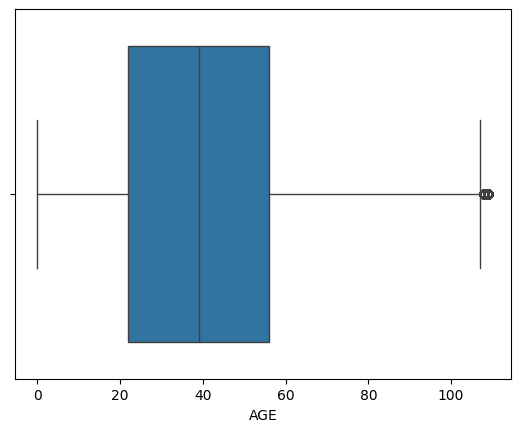

In [26]:
sns.boxplot(x=df_str['AGE'])

plt.show()

In [16]:
def clean_label_text(text):
    if pd.isnull(text):
        return ""

    # Lowercase
    text = text.lower()

    # Remove unwanted qualifiers
    text = re.sub(r'\b(suspected|possible|likely|rule out|probable)\b', '', text)

    # Remove special characters except space
    text = re.sub(r'[^a-z0-9\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Normalize common disease variants
    replacements = {
        r'\bdiarrhoea\b': 'diarrhea',
        r'\bdengue fever\b': 'dengue',
        r'\bdengue infection\b': 'dengue',
        r'\bcovid19\b': 'covid',
        r'\bcovid 19\b': 'covid',
        r'\binfluenza\b': 'flu',
        r'\bcommon cold\b': 'cold',
        r'\bviral infection\b': 'virus infection',
        r'\bstomach flu\b': 'gastroenteritis',
        r'\bhigh blood pressure\b': 'hypertension',
        r'\blow blood pressure\b': 'hypotension',
        r'\bmyocardial infarction\b': 'heart attack',
        r'\bcerebrovascular accident\b': 'stroke',
        r'\bfever\b': 'pyrexia',
        r'\bcough\b': 'cold',
    }

    for pattern, replacement in replacements.items():
        text = re.sub(pattern, replacement, text)

    return text

# Apply the function to the 'label' column
df_str['lebel_text'] = df_str['lebel_text'].apply(clean_label_text)
df_str['lebel_text'].unique()

array(['drug reaction', 'allergy', 'premature ovarian failure', ...,
       'pneumonia bronchitis bronchiectasis panic attack pulmonary embolism nstemi stemi acute copd exacerbation infection unstable angina myocarditis spontaneous pneumothorax pulmonary neoplasm spontaneous rib fracture stable angina guillainbarr syndrome bronchospasm acute asthma exacerbation atrial fibrillation scombroid food poisoning acute dystonic reactions myasthenia gravis anemia chagas acute pulmonary edema psvt sle',
       'flu pneumonia hiv initial infection urti bronchitis chagas tuberculosis acute rhinosinusitis chronic rhinosinusitis anemia scombroid food poisoning',
       'pneumonia bronchitis urti tuberculosis gerd bronchiectasis flu nstemi stemi boerhaave'],
      dtype=object)

In [17]:
pd.DataFrame(df_str['lebel_text'].value_counts())

,count
lebel_text,
localized edema chagas anaphylaxis,21812
cluster headache,10873
cluster headache chagas anemia,10229
acute otitis media,9931
allergic sinusitis,9343
...,...
popliteal artery aneurysm,1
lip cancer,1
hemangioma,1


In [18]:
# Stratified sampling based on 'label_text' column
df_sample = df_str.groupby('lebel_text', group_keys=False).apply(lambda x: x.sample(frac=0.1, random_state=42))

# Verify the sample
df_sample.shape

(111201, 4)

In [19]:
df_sample.to_csv('df_sample.csv', index=False)

In [20]:
import plotly.express as px

def clean_label(label):
    if len(label) > 20:
        return label[:17] + "..."
    return label

top_15_diagnoses = df_sample['lebel_text'].value_counts().head(15).reset_index()
top_15_diagnoses.columns = ['Diagnosis', 'Count']

top_15_diagnoses['Diagnosis'] = top_15_diagnoses['Diagnosis'].apply(clean_label)

fig = px.bar(top_15_diagnoses,
             x='Diagnosis',
             y='Count',
             title='Top 15 Most Common Diagnoses (Sampled Data)',
             labels={'Diagnosis': 'Diagnosis', 'Count': 'Count'},
             color='Count',
             color_continuous_scale='Viridis')

fig.update_layout(xaxis_tickangle=-45,
                  showlegend=False)

fig.show()

In [21]:
diagnoses_gender = df_sample[df_sample['lebel_text'].isin(top_15_diagnoses['Diagnosis'])]
diagnoses_gender = diagnoses_gender.groupby(['lebel_text', 'SEX']).size().reset_index(name='Count')

fig = px.bar(diagnoses_gender,
             x='lebel_text',
             y='Count',
             color='SEX',
             title='Distribution of Diagnoses by Gender',
             labels={'lebel_text': 'Diagnosis', 'Count': 'Count'},
             color_discrete_map={'M': 'blue', 'F': 'pink'},
             barmode='stack')

fig.update_layout(xaxis_tickangle=-45,
                  showlegend=True)

fig.show()

In [22]:
age_diagnoses = df_sample[df_sample['lebel_text'].isin(top_15_diagnoses['Diagnosis'])]

fig = px.box(age_diagnoses,
             x='lebel_text',
             y='AGE',
             title='Age Distribution by Diagnosis',
             labels={'lebel_text': 'Diagnosis', 'AGE': 'Age'},
             color='lebel_text',
             color_discrete_sequence=px.colors.qualitative.Set3)

fig.update_layout(xaxis_tickangle=-45,
                  showlegend=False)

fig.show()

In [32]:
gender_diagnoses = df_sample[df_sample['lebel_text'].isin(top_15_diagnoses['Diagnosis'])]

gender_diagnoses_count = gender_diagnoses.groupby(['lebel_text', 'SEX']).size().reset_index(name='Count')

gender_diagnoses_count['lebel_text'] = gender_diagnoses_count['lebel_text'].apply(clean_label)

fig = px.bar(gender_diagnoses_count,
             x='lebel_text',
             y='Count',
             color='SEX',
             title='Gender Distribution for Top 15 Diagnoses',
             labels={'lebel_text': 'Diagnosis', 'Count': 'Count'},
             color_discrete_sequence=px.colors.qualitative.Set1,
             barmode='stack')

fig.update_layout(xaxis_tickangle=-45, showlegend=True)

fig.show()

In [35]:
age_diagnosis_dist = df_sample.groupby('Age Group').size().reset_index(name='Count')

fig = px.bar(age_diagnosis_dist,
             x='Age Group',
             y='Count',
             title='Age Distribution of Diagnoses',
             labels={'Age Group': 'Age Group', 'Count': 'Count'},
             color_discrete_sequence=px.colors.qualitative.Set2)

fig.update_layout(xaxis_tickangle=-45, showlegend=False)

fig.show()

In [36]:
gender_diagnosis_dist = df_sample.groupby('SEX').size().reset_index(name='Count')

fig = px.bar(gender_diagnosis_dist,
             x='SEX',
             y='Count',
             title='Gender Distribution of Diagnoses',
             labels={'SEX': 'Gender', 'Count': 'Count'},
             color_discrete_sequence=px.colors.qualitative.Set1)

fig.update_layout(showlegend=False)

fig.show()

In [38]:
age_group_diagnoses = df_sample[df_sample['lebel_text'].isin(top_15_diagnoses['Diagnosis'])]
age_group_diagnoses = age_group_diagnoses.groupby(['Age Group', 'lebel_text']).size().reset_index(name='Count')

age_group_diagnoses['lebel_text'] = age_group_diagnoses['lebel_text'].apply(clean_label)

fig = px.bar(age_group_diagnoses,
             x='Age Group',
             y='Count',
             color='lebel_text',
             title='Top Diagnoses in Relation to Age Group',
             labels={'Age Group': 'Age Group', 'Count': 'Count'},
             color_discrete_sequence=px.colors.qualitative.Set3,
             barmode='stack')

fig.update_layout(xaxis_tickangle=-45, showlegend=True)

fig.show()

In [40]:
age_gender_diagnoses = df_sample[df_sample['lebel_text'].isin(top_15_diagnoses['Diagnosis'])]
age_gender_diagnoses = age_gender_diagnoses.groupby(['Age Group', 'SEX', 'lebel_text']).size().reset_index(name='Count')

age_gender_diagnoses['lebel_text'] = age_gender_diagnoses['lebel_text'].apply(clean_label)

fig = px.bar(age_gender_diagnoses,
             x='Age Group',
             y='Count',
             color='SEX',
             facet_col='lebel_text',
             title='Age and Gender Breakdown for Top Diagnoses',
             labels={'Age Group': 'Age Group', 'Count': 'Count'},
             color_discrete_sequence=px.colors.qualitative.Set1,
             barmode='stack',
             facet_col_wrap=3)

fig.update_layout(xaxis_tickangle=-45, showlegend=True)

fig.show()

In [41]:
fig = px.histogram(df_sample,
                   x='AGE',
                   color='SEX',
                   title='Age vs Gender Distribution',
                   labels={'AGE': 'Age', 'SEX': 'Gender'},
                   color_discrete_sequence=px.colors.qualitative.Set1,
                   nbins=30)

fig.update_layout(showlegend=True)

fig.show()

In [43]:
gender_diagnoses = df_sample[df_sample['lebel_text'].isin(top_15_diagnoses['Diagnosis'])]
gender_diagnoses = gender_diagnoses.groupby(['SEX', 'lebel_text']).size().reset_index(name='Count')

gender_diagnoses['lebel_text'] = gender_diagnoses['lebel_text'].apply(clean_label)

fig = px.bar(gender_diagnoses,
             x='lebel_text',
             y='Count',
             color='SEX',
             title='Top Diagnoses for Each Gender',
             labels={'lebel_text': 'Diagnosis', 'Count': 'Count'},
             color_discrete_sequence=px.colors.qualitative.Set1,
             barmode='group')

fig.update_layout(xaxis_tickangle=-45, showlegend=True)

fig.show()

In [47]:
age_diagnosis = df_sample[df_sample['lebel_text'].isin(top_15_diagnoses['Diagnosis'])]
age_diagnosis = age_diagnosis.groupby(['Age Group', 'lebel_text']).size().reset_index(name='Count')

age_diagnosis['lebel_text'] = age_diagnosis['lebel_text'].apply(clean_label)

fig = px.box(age_diagnosis,
             x='lebel_text',
             y='Age Group',
             title='Age Distribution for  the top 15 diagnoses',
             labels={'lebel_text': 'Diagnosis', 'Age Group': 'Age Group'},
             color='lebel_text',
             color_discrete_sequence=px.colors.qualitative.Set2)

fig.update_layout(xaxis_tickangle=-45)

fig.show()